
# 📊 Renewable Quantile Regression for Streaming Data

This notebook demonstrates streaming learning using Renewable Quantile Regression (RQR) on the uploaded time series dataset.

**Key Steps:**  
✅ Load and inspect the dataset  
✅ Implement Renewable Quantile Regression model (summary statistics + incremental update)  
✅ Simulate streaming batches  
✅ Incrementally update and predict quantiles  
✅ Evaluate residuals and detect anomalies  



## ⚙️ Renewable Quantile Regression Model

Below we define a simplified RQR model that maintains summary statistics and performs incremental quantile regression updates using a rolling window approach.


In [3]:
! pip install scikit-learn

  Using cached scipy-1.15.3-cp313-cp313-macosx_14_0_arm64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 2.4 MB/s eta 0:00:00a 0:00:01
Using cached scipy-1.15.3-cp313-cp313-macosx_14_0_arm64.whl (22.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import QuantileRegressor


In [19]:
# Load dataset
df = pd.read_csv('dataset.csv', parse_dates=['datetime'])
df = df.sort_values('datetime').reset_index(drop=True)
display(df.head())


,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [20]:
class RenewableQuantileRegression:
    def __init__(self, quantile=0.5, window_size=500):
        self.quantile = quantile
        self.window_size = window_size
        self.recent_data = []

    def update(self, new_data):
        self.recent_data.extend(new_data)
        if len(self.recent_data) > self.window_size:
            self.recent_data = self.recent_data[-self.window_size:]

    def predict(self, X=None):
        df_window = pd.DataFrame(self.recent_data, columns=['y'])
        df_window['x'] = np.arange(len(df_window))
        model = QuantileRegressor(quantile=self.quantile, alpha=0)
        model.fit(df_window[['x']], df_window['y'])
        if X is None:
            X = np.arange(len(df_window)).reshape(-1,1)
        return model.predict(X)


In [21]:
# Prepare streaming batches
target_variable = 'nat_demand'
stream_data = df[target_variable].values
batch_size = 24  # e.g., hourly data per day
batches = [stream_data[i:i+batch_size] for i in range(0, len(stream_data), batch_size)]

In [25]:
rqr_model = RenewableQuantileRegression(quantile=0.5, window_size=500)
all_predictions = []

for batch in batches:
    rqr_model.update(batch)   # incremental update (summary stats update)
    predictions = rqr_model.predict()
    all_predictions.append(predictions[-1])  # store last quantile prediction
    

/Users/hdimmfh/coding/4_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/Users/hdimmfh/coding/4_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/Users/hdimmfh/coding/4_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/Users/hdimmfh/coding/4_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/Users/hdimmfh/coding/4_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names,

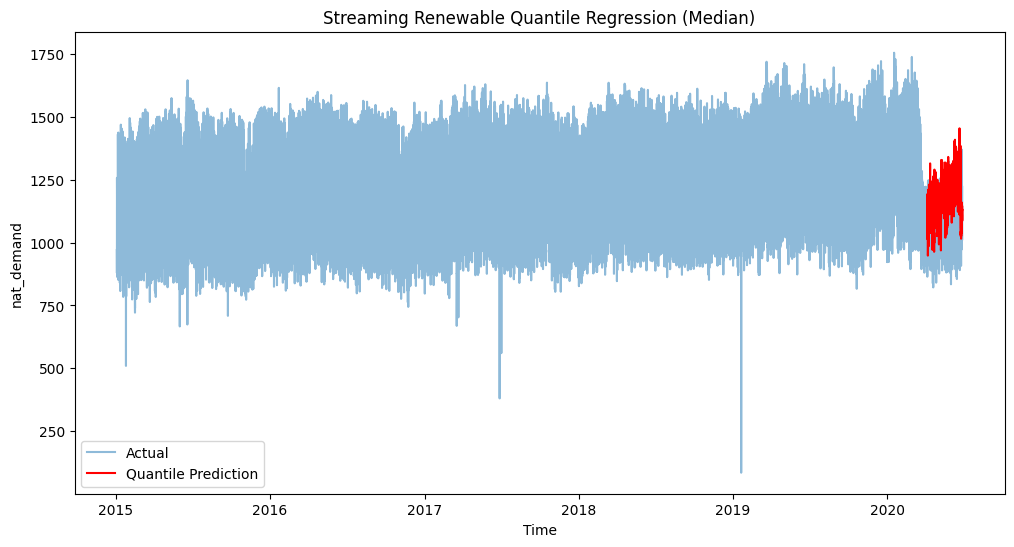

In [26]:
plt.figure(figsize=(12,6))
plt.plot(df['datetime'], df['nat_demand'], label='Actual', alpha=0.5)
pred_times = df['datetime'][len(df) - len(all_predictions):]
plt.plot(pred_times, all_predictions, label='Quantile Prediction', color='red')
plt.xlabel('Time')
plt.ylabel('nat_demand')
plt.legend()
plt.title('Streaming Renewable Quantile Regression (Median)')
plt.show()


## 🔎 Anomaly Detection

Residuals can be analyzed to detect anomalies, e.g., points that exceed a threshold from the predicted quantile.


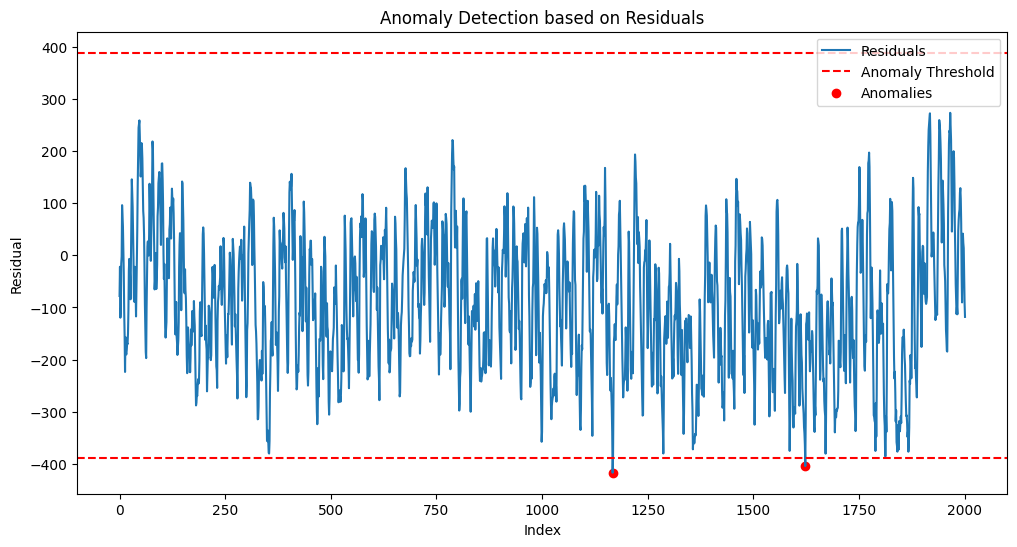

In [27]:

residuals = df['nat_demand'][len(df) - len(all_predictions):].values - np.array(all_predictions)
threshold = 3 * np.std(residuals)
anomalies = np.where(np.abs(residuals) > threshold)[0]

plt.figure(figsize=(12,6))
plt.plot(np.arange(len(residuals)), residuals, label='Residuals')
plt.axhline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.axhline(-threshold, color='red', linestyle='--')
plt.scatter(anomalies, residuals[anomalies], color='red', label='Anomalies')
plt.xlabel('Index')
plt.ylabel('Residual')
plt.legend()
plt.title('Anomaly Detection based on Residuals')
plt.show()

/Users/hdimmfh/coding/4_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/Users/hdimmfh/coding/4_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/Users/hdimmfh/coding/4_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/Users/hdimmfh/coding/4_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but QuantileRegressor was fitted with feature names
  warnings.warn(
/Users/hdimmfh/coding/4_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names,

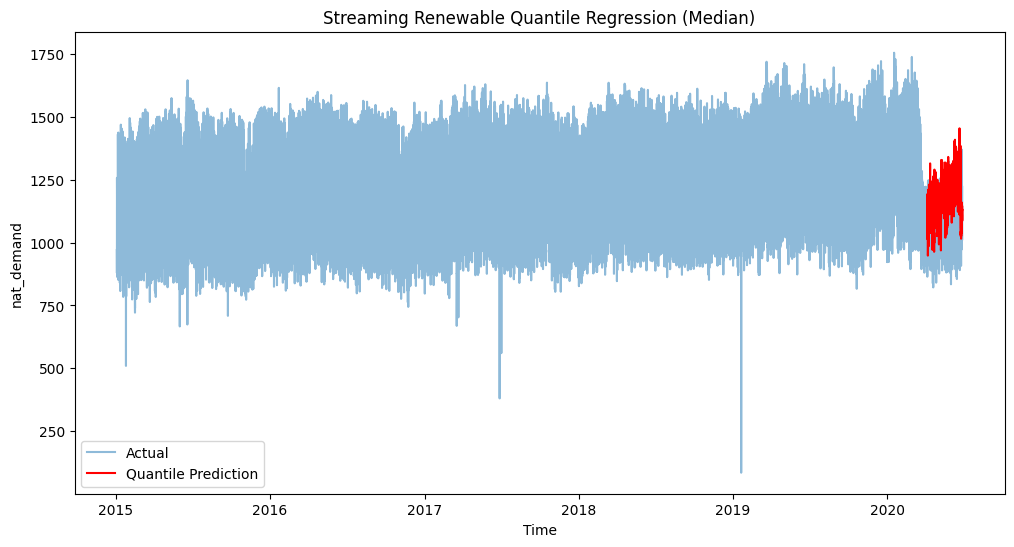

RMSE: 158.23
MAE: 129.81
Overall MAPE: 12.61%


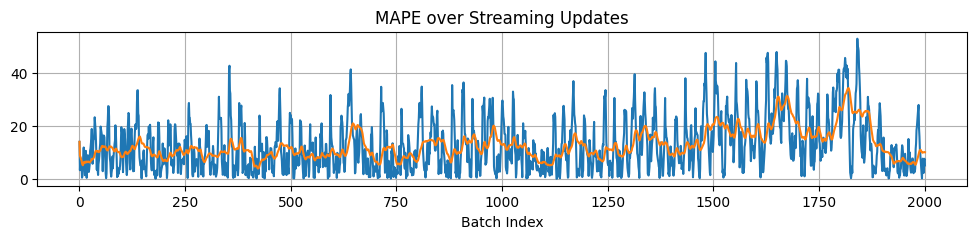

In [39]:
# 📈 Streaming RQR Predictions with MAPE Tracking

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

rqr_model = RenewableQuantileRegression(quantile=0.5, window_size=500)
all_predictions = []
batch_mape_list = []

for batch_idx, batch in enumerate(batches):
    rqr_model.update(batch)
    predictions = rqr_model.predict()
    all_predictions.append(predictions[-1])

    # Calculate MAPE for this batch
    start_idx = len(df) - len(all_predictions)
    actual_batch = df['nat_demand'][start_idx : start_idx + 1].values
    predicted_batch = np.array([predictions[-1]])

    mape = np.mean(np.abs((actual_batch - predicted_batch) / actual_batch)) * 100
    batch_mape_list.append(mape)

# Plot Actual vs. RQR Predictions
plt.figure(figsize=(12,6))
plt.plot(df['datetime'], df['nat_demand'], label='Actual', alpha=0.5)
pred_times = df['datetime'][len(df) - len(all_predictions):]
plt.plot(pred_times, all_predictions, label='Quantile Prediction', color='red')
plt.xlabel('Time')
plt.ylabel('nat_demand')
plt.legend()
plt.title('Streaming Renewable Quantile Regression (Median)')
plt.show()

# Calculate overall RMSE, MAE, MAPE
actual_values = df['nat_demand'][len(df) - len(all_predictions):].values
predicted_values = np.array(all_predictions)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mae = mean_absolute_error(actual_values, predicted_values)
overall_mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Overall MAPE: {overall_mape:.2f}%")

# Plot MAPE over batches
plt.figure(figsize=(12,2))
plt.plot(batch_mape_list)
plt.plot(pd.Series(batch_mape_list).rolling(window=30, min_periods=1).mean())
plt.xlabel('Batch Index')
plt.title('MAPE over Streaming Updates')
plt.grid()
plt.show()
